# Multitasking autoencoder

**We train the autoencoder with a customized loss function. The silent region is mapped onto the average of all QC's, while the other part is just reproduced. This time we remove the part with higher wavenumbers than the silent region to see if the autoencoder performs better.**

In [1]:
amplification= 1000

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers
import pandas as pd

Loading the data

In [3]:
#From Maik
path_data = '//z-sv-dfsroot/dfsroot/project/agzigman/MIRA Anaylzer - Eval/L4L_all_samples/Serum/'   # path for json files

path = '//z-sv-pool12c/pool12c_home/c/Corinna.Wegner/Documents/pilot study/pilot study/' # location of cohort metafiles

meta_full = '//z-sv-pool12c/pool12c_home/c/Corinna.Wegner/Documents/L4L_metatags_Serum_20220719.csv'  

metafile_full = pd.read_csv(meta_full, delimiter=';')
metafile_full = metafile_full[['File Name']]
metafile_full = metafile_full.rename(columns={'File Name':'filename'})
metafile_full = metafile_full.drop_duplicates(subset='filename', keep="first")

metafile_0 = pd.read_excel(path + 'LuCa_VS_NSR_all_samples_excluded1_drifted_train_0_matched.xlsx')
metafile_0 = metafile_0[['filename','cancer_status']]

metafile_1 = pd.read_excel(path + 'LuCa_VS_NSR_all_samples_excluded1_drifted_train_1_matched.xlsx')
metafile_1 = metafile_1[['filename','cancer_status']]

metafile_2 = pd.read_excel(path + 'LuCa_VS_NSR_all_samples_excluded1_drifted_train_2_matched.xlsx')
metafile_2 = metafile_2[['filename','cancer_status']]

# Inner merge of complete metafile with individuals to get intersection between them (From Maik)

merged_0 = pd.merge(left=metafile_full, right=metafile_0, how='inner')
merged_1 = pd.merge(left=metafile_full, right=metafile_1, how='inner')
merged_2 = pd.merge(left=metafile_full, right=metafile_2, how='inner')

In [4]:
import numpy as np
import os.path 
import json as js 

metafiles_labels = {0: merged_0,
                    1: merged_1,
                    2: merged_2}

spectra_path = "//z-sv-dfsroot/dfsroot/project/agzigman/MIRA Anaylzer - Eval/L4L_all_samples/Serum"

absorbances = []
labels = []

for label, metafile in metafiles_labels.items():
    for i in range(1, len(metafile)):
        #k=0
        ID = metafile["filename"][i] + ".json"
        spectrum_path_id ="%s/%s"%(spectra_path,ID) 
        if os.path.isfile(spectrum_path_id):
            f = open(spectrum_path_id, "r")
            spect = js.loads(f.read(), strict=False)
            ab_data = spect["AB Data"]
            ab_data = list(reversed(ab_data))
            absorbances.append(ab_data)
            labels.append(label)
        else:
            print('no file found')
        
absorbances = np.array(absorbances)

Defining custom loss function with an amplification parameter that increases the loss for the silent region, making it more important.

In [5]:
x_data =  absorbances #data with the spectra

#extracting silent region from x
range_silent = [1800, 2300]

vec = pd.read_csv(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\sample.txt", sep='\t')
vec = vec.X
vec_ = vec.to_list()

for i in range(len(vec_)):
    if vec_[i]<range_silent[0] and vec[i+1]>=range_silent[0]:
        min_index = i+1
    if vec_[i]<=range_silent[1] and vec[i+1]>range_silent[1]:
        max_index = i
        
silent_region = [spect[min_index:max_index] for spect in absorbances]
silent_region = np.array(silent_region)

#averaging qc spectra
qcs = np.loadtxt("qcs_real.txt", delimiter=",")
avg_qc = np.average(qcs, axis=0)

#defining amplification parameters for the loss of the silent region
amplification_params = [1, 10, 100, 1000]
amplification = amplification

def custom_loss(y_true, y_pred):
    silent_qc = avg_qc[min_index:max_index]
    loss1 = tf.keras.losses.mean_squared_error(y_true[:min_index], y_pred[:min_index])
    loss2 = amplification*tf.keras.losses.mean_squared_error(silent_qc, y_pred[min_index:max_index])
    #loss3 = tf.keras.losses.mean_squared_error(y_true[max_index:], y_pred[max_index:])
    return tf.concat([loss1,loss2], axis=0)

Preprocessing

In [6]:
#from scipy.signal import savgol_filter
#Savgol filter
#x_data = savgol_filter(x_data, window_length = 9, polyorder=2, deriv=1)

#splitting data into train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(x_data, test_size=0.2, random_state=42, shuffle=True, stratify=None)

#normalizing the data
from sklearn.preprocessing import normalize
train_normalized = normalize(train, norm='l2')
test_normalized = normalize(test, norm='l2')

#standard scaling the training data
from sklearn.preprocessing import StandardScaler
standardscaler_test = StandardScaler()
standardscaler_train = StandardScaler()
test_scaled = standardscaler_test.fit_transform(test_normalized)
train_scaled = standardscaler_train.fit_transform(train_normalized)

#reshaping the data
train = train_scaled.reshape(train.shape[0],train.shape[1],1)
test_scaled = test_scaled.reshape(test_scaled.shape[0],test_scaled.shape[1],1)

Defining and training the model

In [7]:
#https://www.kaggle.com/code/kmkarakaya/1-dimensional-convolution-conv1d-for-regression really nice documentation
#https://keras.io/examples/timeseries/timeseries_anomaly_detection/
activation = "elu"
filter_size = 53
strides = 2
num_filters1 = 16
num_filters2 = 32
num_filters3 = 64
num_filters4 = 128

model = keras.models.Sequential(name="autoencoder_conv1d")
model.add(layers.InputLayer(input_shape=(train.shape[1],train.shape[2])))
model.add(layers.Conv1D(num_filters4, filter_size, strides))
model.add(layers.Conv1D(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters1, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters4, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(1,filter_size, strides=strides, activation=activation))  

print(model.summary())

Model: "autoencoder_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 525, 128)          6912      
                                                                 
 conv1d_1 (Conv1D)           (None, 237, 64)           434240    
                                                                 
 conv1d_2 (Conv1D)           (None, 93, 32)            108576    
                                                                 
 conv1d_3 (Conv1D)           (None, 21, 16)            27152     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 93, 32)           27168     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 237, 64)          108608    
 ranspose)                                      

In [8]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss=custom_loss)

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

results = model.fit(train, train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[earlystopping, rl_on_plateau])

Epoch 1/50
11/11 [==============================] - 22s 2s/step - loss: 0.8220 - val_loss: 0.7359 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 20s 2s/step - loss: 0.5762 - val_loss: 0.5072 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 20s 2s/step - loss: 0.4220 - val_loss: 0.4127 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 20s 2s/step - loss: 0.3404 - val_loss: 0.3288 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 20s 2s/step - loss: 0.2808 - val_loss: 0.2666 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 20s 2s/step - loss: 0.2243 - val_loss: 0.2276 - lr: 0.0010
Epoch 7/50
11/11 [==============================] - 20s 2s/step - loss: 0.1902 - val_loss: 0.1978 - lr: 0.0010
Epoch 8/50
11/11 [==============================] - 20s 2s/step - loss: 0.1669 - val_loss: 0.1726 - lr: 0.0010
Epoch 9/50
11/11 [==============================] - 20s 2s/step - loss: 0.1536 - val_loss: 0.1674 - lr: 0.0010
E

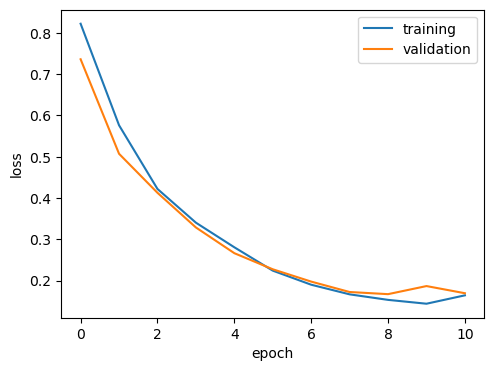

In [9]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')

## Evaluating the performance of the model

In [10]:
preds = model.predict(test_scaled, verbose=1)
preds_rescaled = tf.squeeze(preds)#standardscaler_test.inverse_transform(tf.squeeze(preds))##

12/12 [==============================] - 2s 179ms/step


In [11]:
"""
plots = 2
n_test = test.shape[0]
idx = np.random.choice(n_test, plots)
xaxis = np.linspace(929.52720343237377,3050.8548461203636,test.shape[1])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))

for i in range(plots):
    ax1[i].plot(xaxis, test[idx[i]],'b', markersize= 0.5, label="original spectrum")
    ax1[i].plot(xaxis, preds_rescaled[idx[i]], 'r', markersize=0.5, label="spectrum after autoencoder")
    
    ax1[i].legend(loc=1)
    ax1[i].set_xlabel('wavenumber [cm$^-1$]')
    ax2[i].set_xlabel('wavenumber [cm$^-1$]')
    ax1[i].set_ylabel('Absorbance [a.u.]')
    ax1[i].set_title("spectra")

    ax2[i].plot(xaxis, np.abs(test[idx[i]]-preds_rescaled[idx[i]]), label="residuals")
    ax2[i].plot(xaxis, np.zeros(xaxis.shape), 'k')
    
    ax2[i].set_title("residuals")
    
plt.tight_layout()
plt.show()
"""

'\nplots = 2\nn_test = test.shape[0]\nidx = np.random.choice(n_test, plots)\nxaxis = np.linspace(929.52720343237377,3050.8548461203636,test.shape[1])\n\nfig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))\n\nfor i in range(plots):\n    ax1[i].plot(xaxis, test[idx[i]],\'b\', markersize= 0.5, label="original spectrum")\n    ax1[i].plot(xaxis, preds_rescaled[idx[i]], \'r\', markersize=0.5, label="spectrum after autoencoder")\n    \n    ax1[i].legend(loc=1)\n    ax1[i].set_xlabel(\'wavenumber [cm$^-1$]\')\n    ax2[i].set_xlabel(\'wavenumber [cm$^-1$]\')\n    ax1[i].set_ylabel(\'Absorbance [a.u.]\')\n    ax1[i].set_title("spectra")\n\n    ax2[i].plot(xaxis, np.abs(test[idx[i]]-preds_rescaled[idx[i]]), label="residuals")\n    ax2[i].plot(xaxis, np.zeros(xaxis.shape), \'k\')\n    \n    ax2[i].set_title("residuals")\n    \nplt.tight_layout()\nplt.show()\n'

One does not see the difference in the silent regions, because it is too small. To investigate the differences between the spectra we therefore perform a t-SNE of the test set before and after the autoencoder (only the silent region).

In [12]:
test_sc = tf.squeeze(test_scaled)
preds_sc = preds_rescaled

#silent region
test_silent = [spect[min_index:max_index] for spect in test_sc]
test_silent = np.array(test_sc)

preds_silent = [spect[min_index:max_index] for spect in preds_sc]
preds_silent = np.array(preds_sc)

#other region of the spectrum
test_lr = [spect[:min_index] for spect in test_sc]
test_lr = np.array(test_lr)

preds_lr = [spect[:min_index] for spect in preds_sc]
preds_lr = np.array(preds_lr)

In [13]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
tsne_results_before = tsne.fit_transform(test_silent)
tsne_results_after = tsne.fit_transform(preds_silent)

x_tsne = tsne_results_before[:,0]
y_tsne = tsne_results_before[:,1]

x_tsne_a = tsne_results_after[:,0]
y_tsne_a = tsne_results_after[:,1]

tsne_df_b = pd.DataFrame(dict(x=x_tsne, y=y_tsne, label="original spectra"))
tsne_df_a = pd.DataFrame(dict(x=x_tsne_a, y=y_tsne_a, label="spectra after autoencoder"))
tsne_df = pd.concat([tsne_df_b, tsne_df_a])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 363 samples in 0.000s...
[t-SNE] Computed neighbors for 363 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 363 / 363
[t-SNE] Mean sigma: 11.060219
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.095833
[t-SNE] KL divergence after 500 iterations: 0.731465
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 363 samples in 0.000s...
[t-SNE] Computed neighbors for 363 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 363 / 363
[t-SNE] Mean sigma: 10.463978


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.038284
[t-SNE] KL divergence after 500 iterations: 0.579431


Text(0.5, 1.0, 'T-SNE of the silent region')

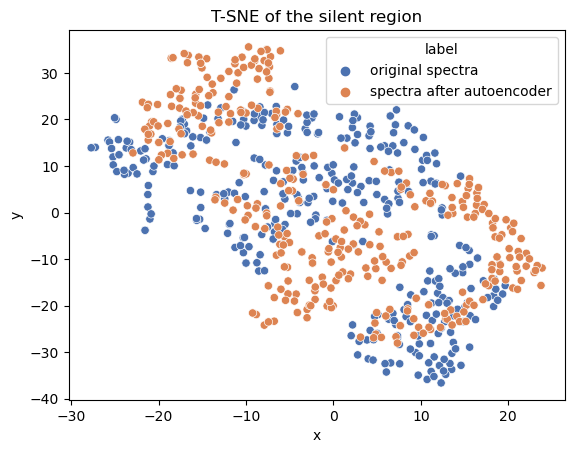

In [14]:
import seaborn as sns
sns.scatterplot(data=tsne_df, x="x", y="y", hue="label", palette="deep")
plt.title("T-SNE of the silent region")

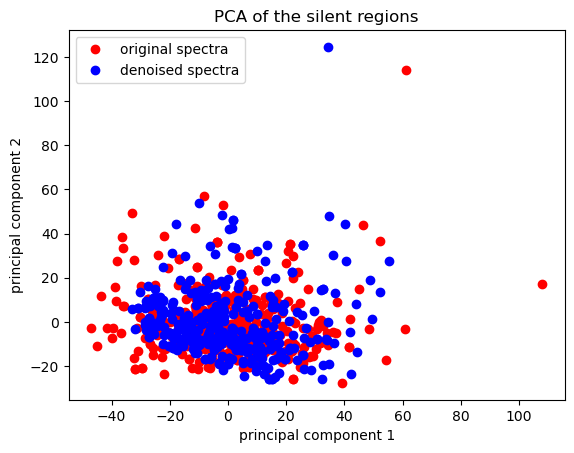

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(test_silent)
principalComponents_a = pca.fit_transform(preds_silent)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf_a = pd.DataFrame(data = principalComponents_a, columns = ['principal component 1', 'principal component 2'])

xaxis = list(principalDf["principal component 1"])
yaxis = list(principalDf["principal component 2"])
xaxis_a = list(principalDf_a["principal component 1"])
yaxis_a = list(principalDf_a["principal component 2"])

plt.plot(xaxis, yaxis, 'ro', label = "original spectra")#, markersize= 0.5)
plt.plot(xaxis_a, yaxis_a, 'bo', label='denoised spectra')#, markersize= 0.5)

plt.title("PCA of the silent regions")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.legend()

In [16]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE

#select 10 random pairs out of the testset to perform T-SNE on
random_indices = np.random.randint(0, test_lr.shape[0], size=10)
test_random = np.array([test_lr[idx] for idx in random_indices])
preds_random = np.array([preds_lr[idx] for idx in random_indices])

tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
tsne_results_before = tsne.fit_transform(test_random)
tsne_results_after = tsne.fit_transform(preds_random)

x_tsne = tsne_results_before[:,0]
y_tsne = tsne_results_before[:,1]

x_tsne_a = tsne_results_after[:,0]
y_tsne_a = tsne_results_after[:,1]

tsne_df_b = pd.DataFrame(dict(x=x_tsne, y=y_tsne, label="original spectra"))
tsne_df_a = pd.DataFrame(dict(x=x_tsne_a, y=y_tsne_a, label="spectra after autoencoder"))
tsne_df_lr = pd.concat([tsne_df_b, tsne_df_a])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.922035
[t-SNE] KL divergence after 500 iterations: 0.250859
[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.030975
[t-SNE] KL divergence after 500 iterations: 0.253700


Text(0.5, 1.0, 'T-SNE of the relevant part of the specta')

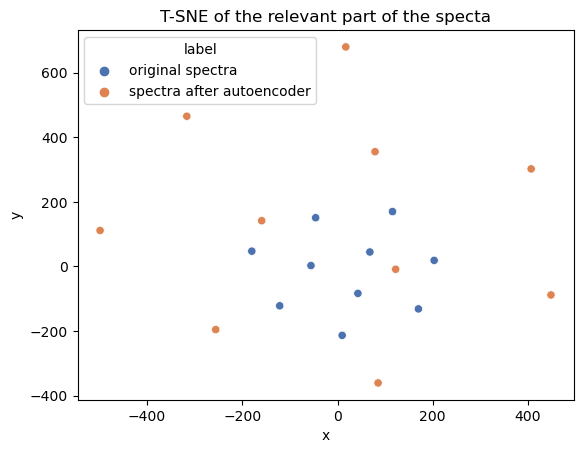

In [17]:
import seaborn as sns
sns.scatterplot(data=tsne_df_lr, x="x", y="y", hue="label", palette="deep")
plt.title("T-SNE of the relevant part of the specta")

Je kleiner der amplification parameter
Parameter 350: zu wenig verkleinerung in PCA, gute tsne vom relevanten part
Parameter 500: zu wenig verkleinerung in PCA, sehr gute tsne vom relevanten part
Parameter 1000: PCA verkleinerung ok, schlechte tsne

als nächstes normalisierung von Train und test probieren, nicht vergessen es auch genau so bei loss_function_engineering_1 zu machen